# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0k/60.0k [03:11<00:00, 313File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

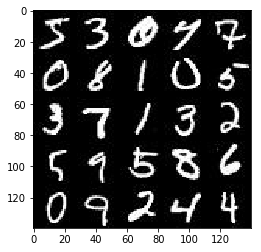

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

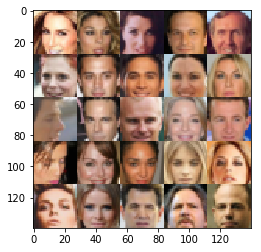

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [47]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    lr = tf.placeholder(tf.float32, [], name="lr")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [48]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # images are 28x28x3
        
        # makes 14x14x32
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # do not use batch norm on the first conv layer
        relu1 = tf.maximum(alpha * x1, x1)
        
        # makes 7x7x128
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        # makes 4x4x256
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [49]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    kernel_size = 5
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected layer
        x1 = tf.layers.dense(z, 7*7*64)
        
        # start convolution with 7x7x64
        x1 = tf.reshape(x1, (-1, 7, 7, 64))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # transform to 14x14x32
        x2 = tf.layers.conv2d_transpose(x1, 32, kernel_size, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # transform to 28x28x16
        x3 = tf.layers.conv2d_transpose(x2, 16, kernel_size, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # transform to 28x28x8
        x4 = tf.layers.conv2d_transpose(x3, 8, kernel_size, strides=1, padding='same', activation=None)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # output layer, is 28x28x[channels]
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, kernel_size, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [50]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # model perform
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
        
    # calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [51]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, tf_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, tf_learning_rate, beta1)
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # random input for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale images from -1 to 1
                batch_images = batch_images * 2
                
                # train discriminator with real and fake images, generator with just fake
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, tf_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, tf_learning_rate: learning_rate})
                
                if steps % 100 == 0:
                    show_generator_output(sess, 36, input_z, data_shape[3], data_image_mode)
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
        saver.save(sess, "./checkpoints/generator.ckpt")
        print("Last Output:")
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.2517... Generator Loss: 5.2244
Epoch 1/2... Discriminator Loss: 2.2129... Generator Loss: 2.7495
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 1.7149
Epoch 1/2... Discriminator Loss: 1.6143... Generator Loss: 1.9089
Epoch 1/2... Discriminator Loss: 1.6814... Generator Loss: 1.6895
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 1.4493
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 1.0574
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 1.6022


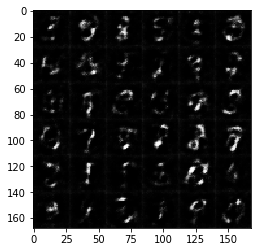

Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 1.6098
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 1.4964
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 1.5738
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 1.3980
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 1.7892
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 1.0407
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 1.6414


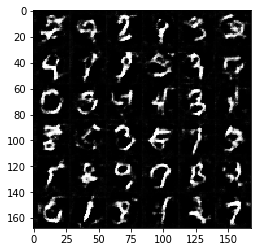

Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 1.4940
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 1.5446
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 1.4433
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.7124
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.9708
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 1.4270
Epoch 1/2... Discriminator Loss: 1.4861... Generator Loss: 0.4550
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.7700


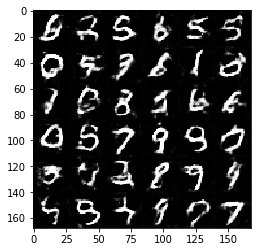

Epoch 1/2... Discriminator Loss: 1.6392... Generator Loss: 0.3854
Epoch 1/2... Discriminator Loss: 1.6923... Generator Loss: 0.3578
Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 2.0280... Generator Loss: 0.2316
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 1.1998
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.4664


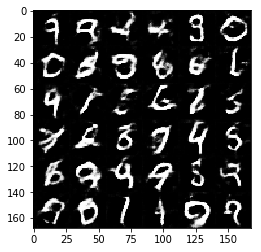

Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.5938... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7715


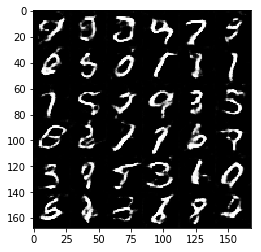

Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.5553
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 1.0549
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.6453


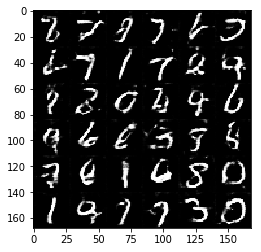

Epoch 2/2... Discriminator Loss: 1.4787... Generator Loss: 0.4562
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.8352
Epoch 2/2... Discriminator Loss: 1.5812... Generator Loss: 1.5608
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.5164... Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 1.2237
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 1.1370
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 1.0738


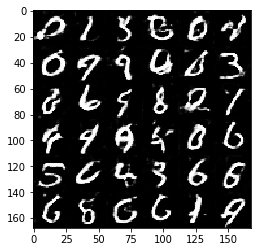

Epoch 2/2... Discriminator Loss: 1.4443... Generator Loss: 0.4817
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.7548
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 1.4827
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 1.1446
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 2.2211... Generator Loss: 0.1971
Epoch 2/2... Discriminator Loss: 1.5665... Generator Loss: 0.4001


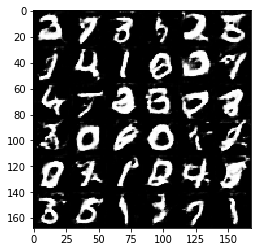

Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.6621
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.6078... Generator Loss: 0.3772
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 1.6634... Generator Loss: 1.7050
Epoch 2/2... Discriminator Loss: 1.2735... Generator Loss: 0.7216


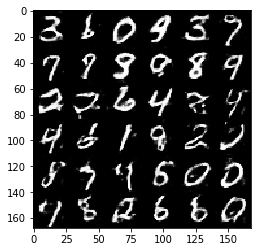

Epoch 2/2... Discriminator Loss: 1.6933... Generator Loss: 1.5151
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.9792
Epoch 2/2... Discriminator Loss: 1.6181... Generator Loss: 0.3779
Last Output:


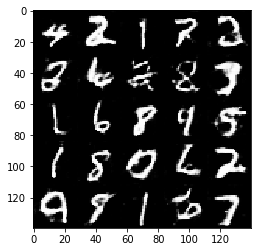

In [56]:
batch_size =128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0627... Generator Loss: 8.5084
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.5244
Epoch 1/1... Discriminator Loss: 1.9336... Generator Loss: 4.7770
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.8311
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 2.5521
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 2.3730


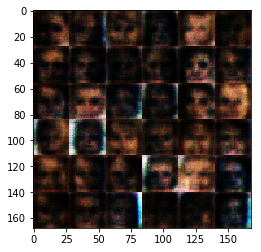

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 2.4409
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.6434
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 1.6730
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.4333


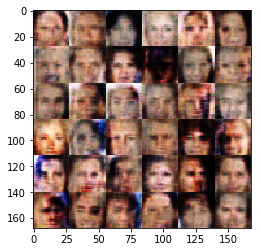

Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.9477


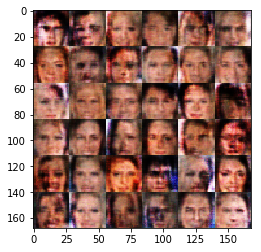

Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 1.6031


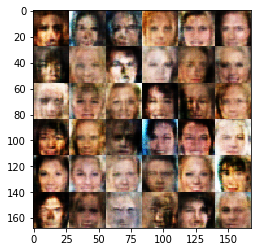

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.4646
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6497


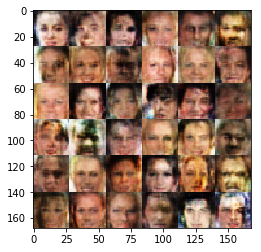

Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.4169
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.3053
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 1.1217


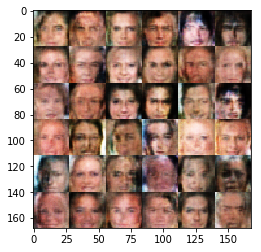

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 1.6199
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.4917


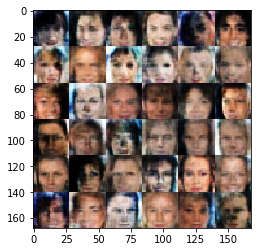

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.5981


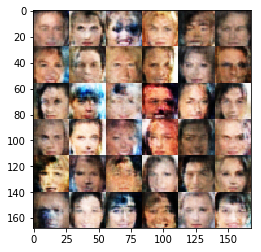

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.6952


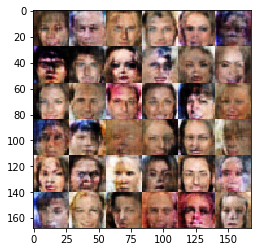

Epoch 1/1... Discriminator Loss: 1.8699... Generator Loss: 0.2768
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 0.2674
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.5804


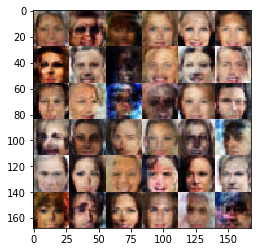

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.0206


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.